# Petrophysics with Petrolib Software Package 

Petrolib is a python software package that is designed to handle petrophysical workflow of evaluating a reservoir/formation. 

It has the capability of estimating petrophysical parameters such as:

* Volume of Shale using various methods like Clavier, Stieber and Larionov methods
* Porosity - Effective and Total porosities using the density and Wyllie's sonic methods.
* Water Saturation - using both archie and simmandoux methods
* Permeability

## Functionalities
The package is designed to handle:

* Loading of well data
* Processing of well log data
* Statistical analysis such as log frequencies and correlation
* Well log visualisation (with superimposed view)
* Plot well locations on an actual map
* Facilitates the loading of well tops.
* Plot log curves along with zonation tracks
* Neutron-density cross plot
* Pickett Plot

#### In this tutorial, I will be demonstrating how petrolib can be used

# Package Installation

In [1]:
#install package

%pip install petrolib==1.2.4.1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
#load packages
import pandas as pd
from pathlib import Path
from warnings import filterwarnings
from matplotlib import pyplot as plt
filterwarnings('ignore')

import petrolib

from petrolib.file_reader import load_las
from petrolib.procs import process_data, set_alias, trim, model_facies
from petrolib.stats import displayFreq, Correlation
from petrolib.interp import crossPlot, picketPlot
from petrolib.plots import *
from petrolib.workflow import Quanti

In [16]:
#checks the version of package
petrolib.__version__

'1.2.4.1'

# Data

This section:

* gets all the LAS files in the folder and read specific log curves into memory. By default, the `load_las` function read the depth logs into memory. Here the three-combo logs are selected for petrophysics workflow. 

* The logs are also renamed to conventional names. You can leverage on the `rename` function of pandas dataframe or the `set_alias` function available in `petrolib`. 

* The log curves are also treated for arbitrary values. The `process_data` function will help treated underepresented values in the logs and condition them into acceptable value ranges.

In [5]:
path = Path('./')
#gets all LaS files in directory 
from glob import glob
paths = sorted(glob('data/*.las'))

wells = list()
for well in paths:
    df, _ = load_las(str('./')+well, return_csv=True, curves=['GR', 'ILD', 'RHOB', 'NPHI'])
    wells.append(set_alias(df.reset_index(), 'DEPT:1', 'GR', 'ILD', 'NPHI', 'RHOB'))

well10, well11 = wells


In [6]:
#to normalise the neutron porosity values
well11['NPHI'] = well11['NPHI']/100
well10['NPHI'] = well10['NPHI']/100

In [7]:
#processing the data of arbitrary valuesa
df = process_data(well11, 'GR', 'RT', 'NPHI', 'RHOB')
df.describe()

DEPTH            GR            RT          RHOB          NPHI
count  21442.000000  21442.000000  19355.000000  11550.000000  10536.000000
mean    2826.181800     55.170207     21.169472      2.277493      0.291119
std      943.343286     30.798939    104.083570      0.093732      0.089807
min     1192.377600     14.791000      1.272500      1.950000      0.035533
25%     2009.279700     25.843800      2.189500      2.206100      0.220202
50%     2826.181800     44.125000      3.259700      2.273200      0.281065
75%     3643.083900     85.907188     16.742200      2.347088      0.364935
max     4459.986000    143.250000   1950.000000      2.677700      0.450000

In [28]:
#alternatively you can use the `trim` function but you have to specify the lowe and upper limits
logs = well10.columns[1:]
l_limit = (0, 0.2, 1.95, -0.15)
u_limit = (200, 2000, 2.95, 0.45)

for log, lower, upper in zip(logs, l_limit, u_limit):
    new_well10 = trim(well10, log, lower, upper)

well10.describe()

DEPTH            GR           RT          RHOB          NPHI
count  21362.000000  12108.000000  3773.000000  11994.000000  11131.000000
mean    2707.919400     65.141053    39.685892      2.294954      0.296344
std      939.823758     27.784838   160.188059      0.105071      0.090987
min     1080.211200      0.000000     0.200000      2.001182     -0.040480
25%     1894.065300     38.388225     2.675000      2.214700      0.228057
50%     2707.919400     70.623798     3.931000      2.290500      0.285156
75%     3521.773500     89.452353     6.556900      2.375900      0.371447
max     4335.627600    142.546906  2000.000000      2.614600      0.450000

### Data Statistics



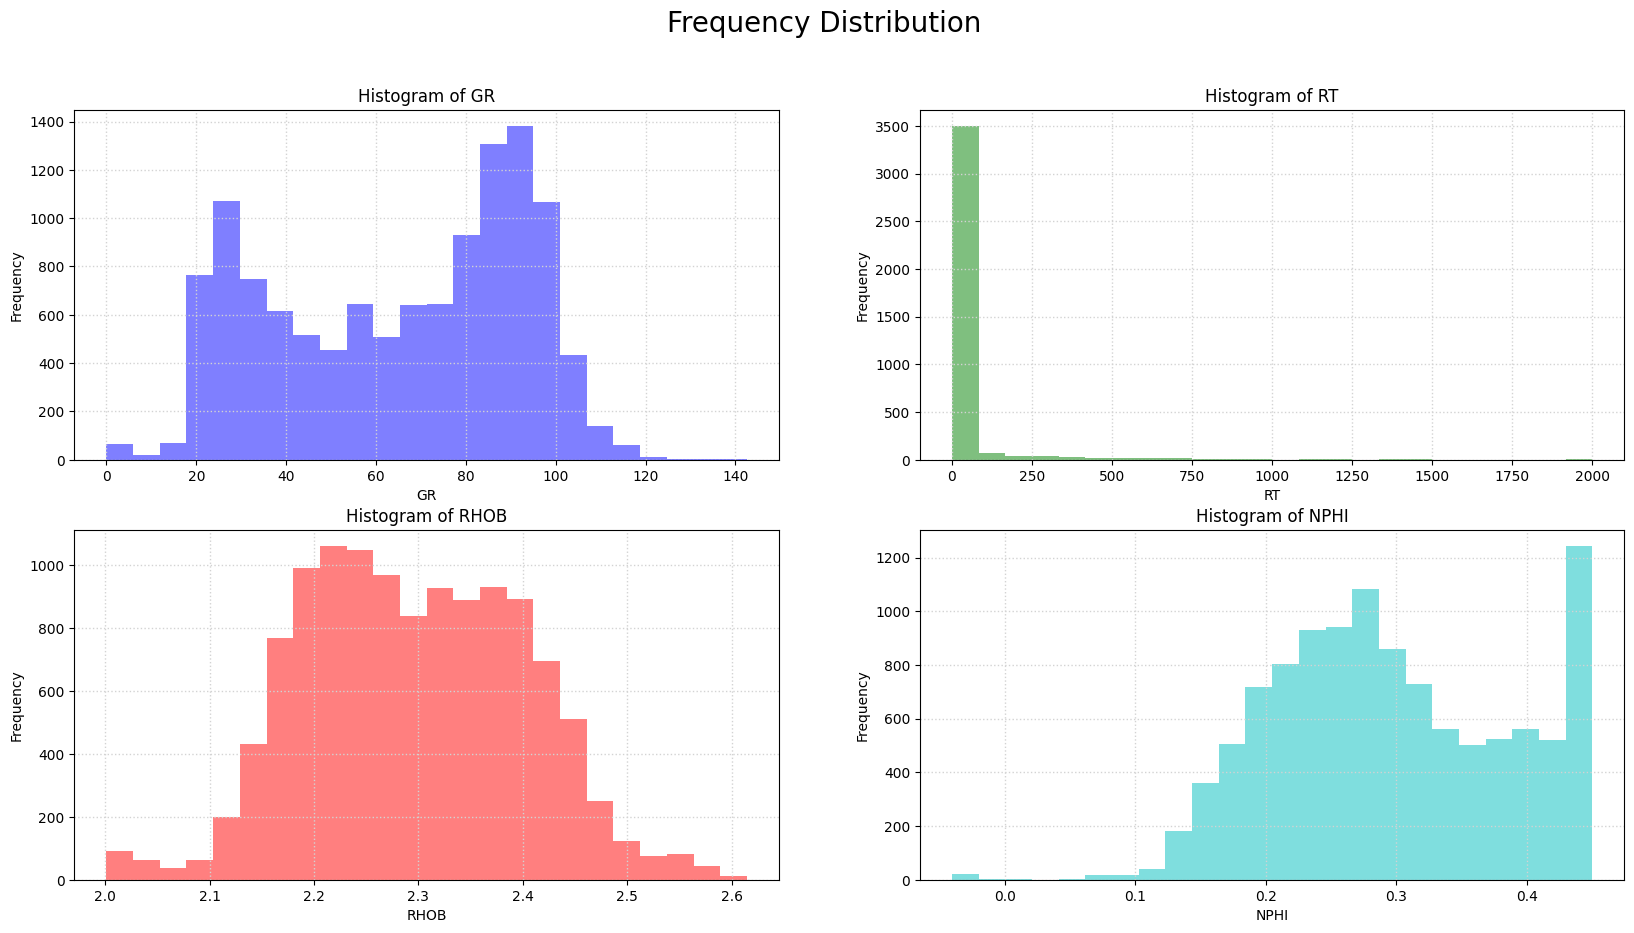

In [84]:
displayFreq(well10, *(well10.columns[1:]), figsize=(20, 10), bins=24)

In [85]:
#leverage on the correlation class to determine linear and non relationship between logs
# chatter jee helps to determine the non-linear relation
corr = Correlation(well10)
chatterjee = corr.corr(method='chatterjee')
chatterjee

DEPTH        GR        RT      RHOB      NPHI
DEPTH  0.999860  0.719682  0.976574  0.760602  0.759891
GR     0.965442  0.999921  0.914303  0.753198  0.762302
RT     0.998195  0.988988  0.999976  0.988950  0.992067
RHOB   0.956795  0.762479  0.911962  0.999921  0.740539
NPHI   0.969718  0.798798  0.933017  0.773809  0.999929

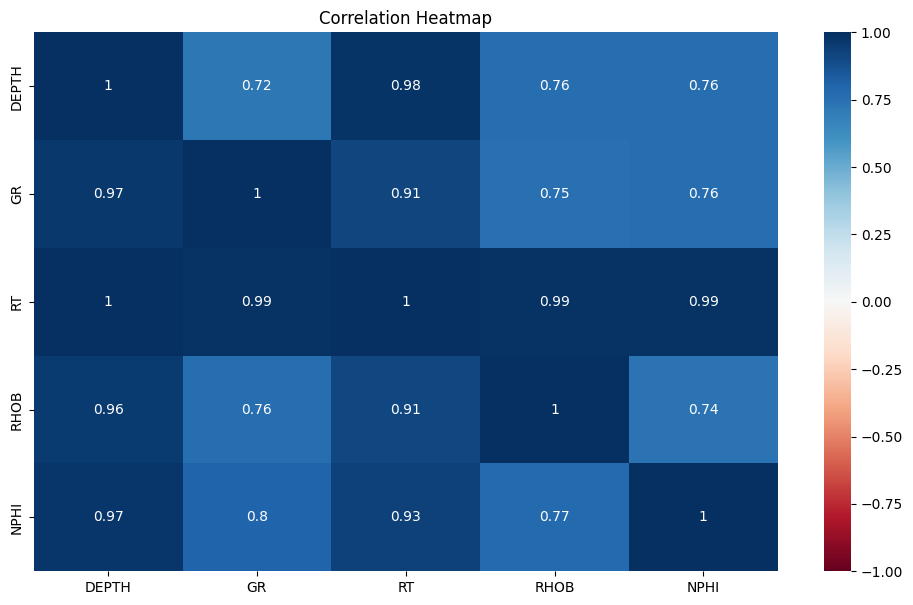

In [86]:
corr.plot_heatmap(cmap='RdBu')

# Plots

* You can model the lithofacies of the well data from gamma ray log using the `model_facies` function. It is assumed you're working in a sliliclastic (`SS`) envrironment. You can also model the lithofacies for the carbonate (`CO`) environment too. The resulting dataframe create a new log column named `litho` with the lithofacies.

* You can plot the lithofacies alongside, other logs. The logs can be plotted singly or superimposed on each other in the same track. The line colors for the logs are randomly assigned. 

In [29]:
df = model_facies(well11, 'GR', env='SS')

df

DEPTH          GR      RT  RHOB  NPHI      litho
0      1192.3776   18.624901     NaN   NaN   NaN  Sandstone
1      1192.5300   18.484600     NaN   NaN   NaN  Sandstone
2      1192.6824   18.877001     NaN   NaN   NaN  Sandstone
3      1192.8348   21.032200     NaN   NaN   NaN  Sandstone
4      1192.9872   22.497999     NaN   NaN   NaN  Sandstone
...          ...         ...     ...   ...   ...        ...
21437  4459.3764  108.000000  2.1367   NaN   NaN      Shale
21438  4459.5288  108.000000  2.1367   NaN   NaN      Shale
21439  4459.6812  108.000000  2.1367   NaN   NaN      Shale
21440  4459.8336  108.000000  2.1348   NaN   NaN      Shale
21441  4459.9860  108.000000  2.1367   NaN   NaN      Shale

[21442 rows x 6 columns]

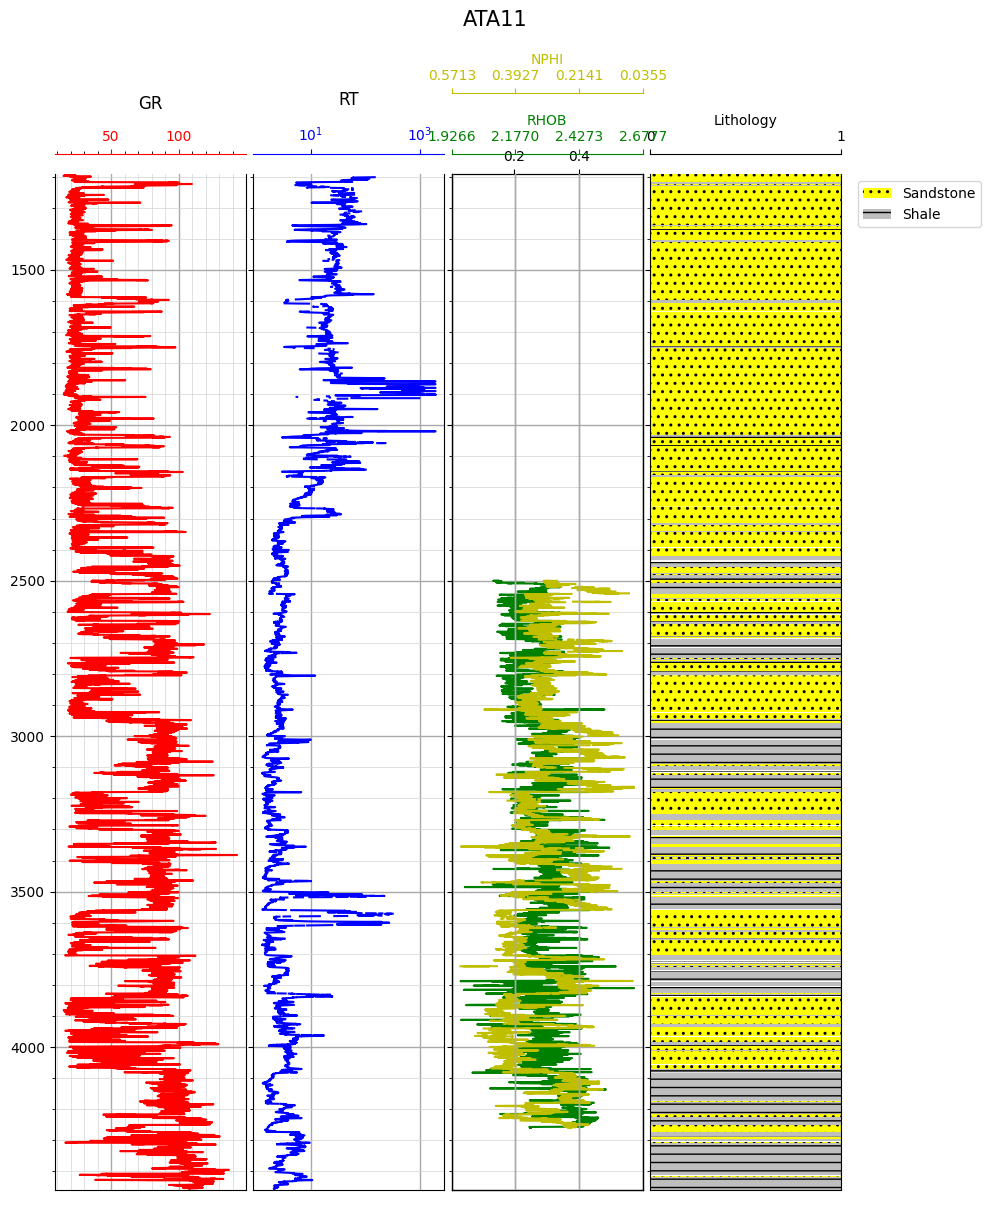

In [98]:
plotLogFacies(well11, 'DEPTH', ['GR', 'RT', ['RHOB', 'NPHI']], top=well11.DEPTH.min(), facies='litho',
                            bottom=well11.DEPTH.max(), figsize=(10, 12), title='ATA11')

you can plot the logs (excluding the lithofacies) singly by using `plotLog`

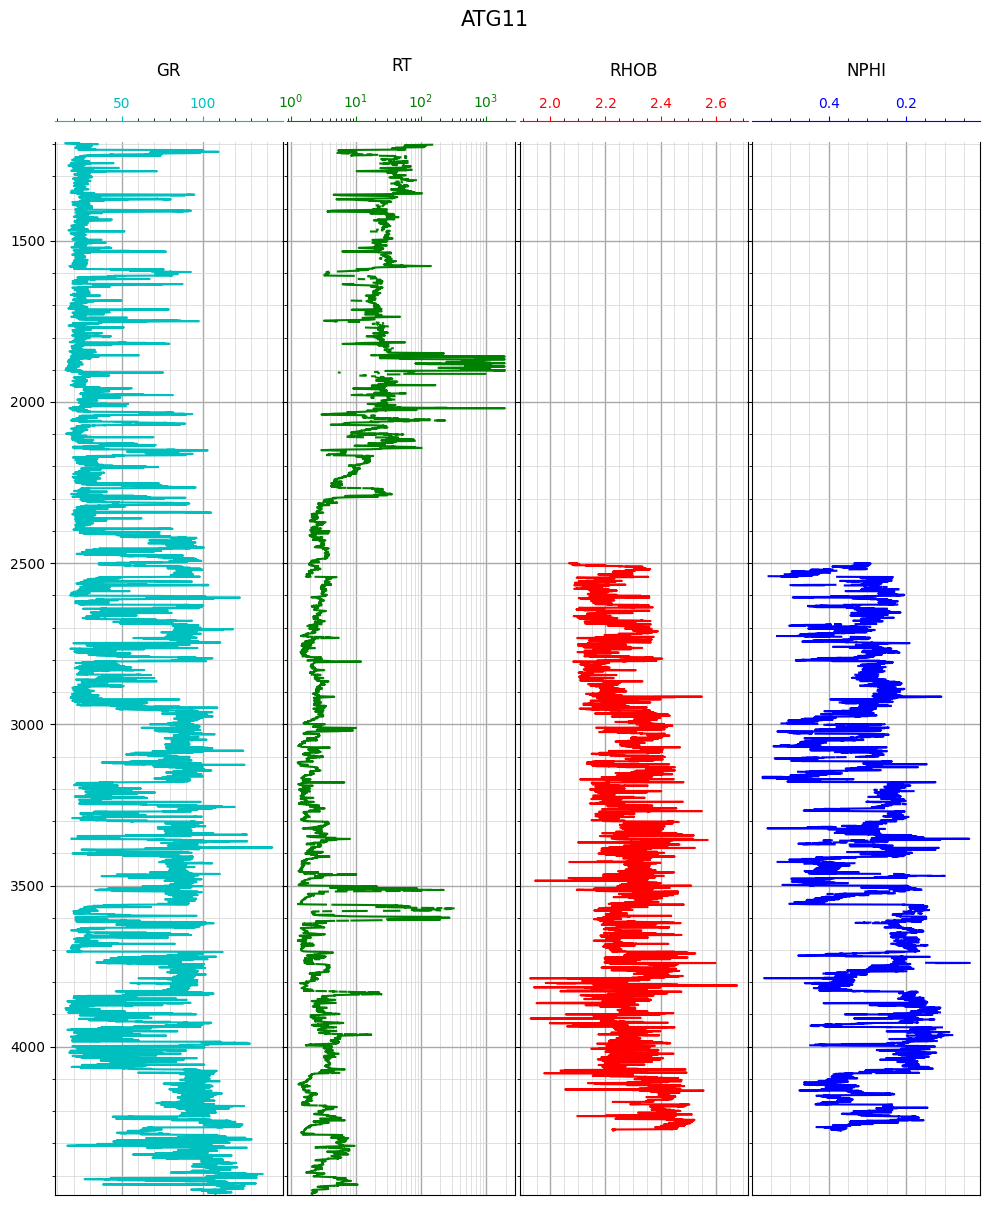

In [99]:
plotLog(well11, 'DEPTH', ['GR', 'RT', 'RHOB', 'NPHI'], top=well11.DEPTH.min(),
                            bottom=well11.DEPTH.max(), figsize=(10, 12), title='ATG11')

Plots the three-combo logs. 

* Reveal the hydrocarbon zones by setting the `res_thres` parameter
* Reveal the shale sand sequence by setting `limit` and `palette_op`  arguments to `None`
* Show only porous zones by setting `fill=left`, non-porous zones as `fill=right`, both porous and non-porous as `fill=both`


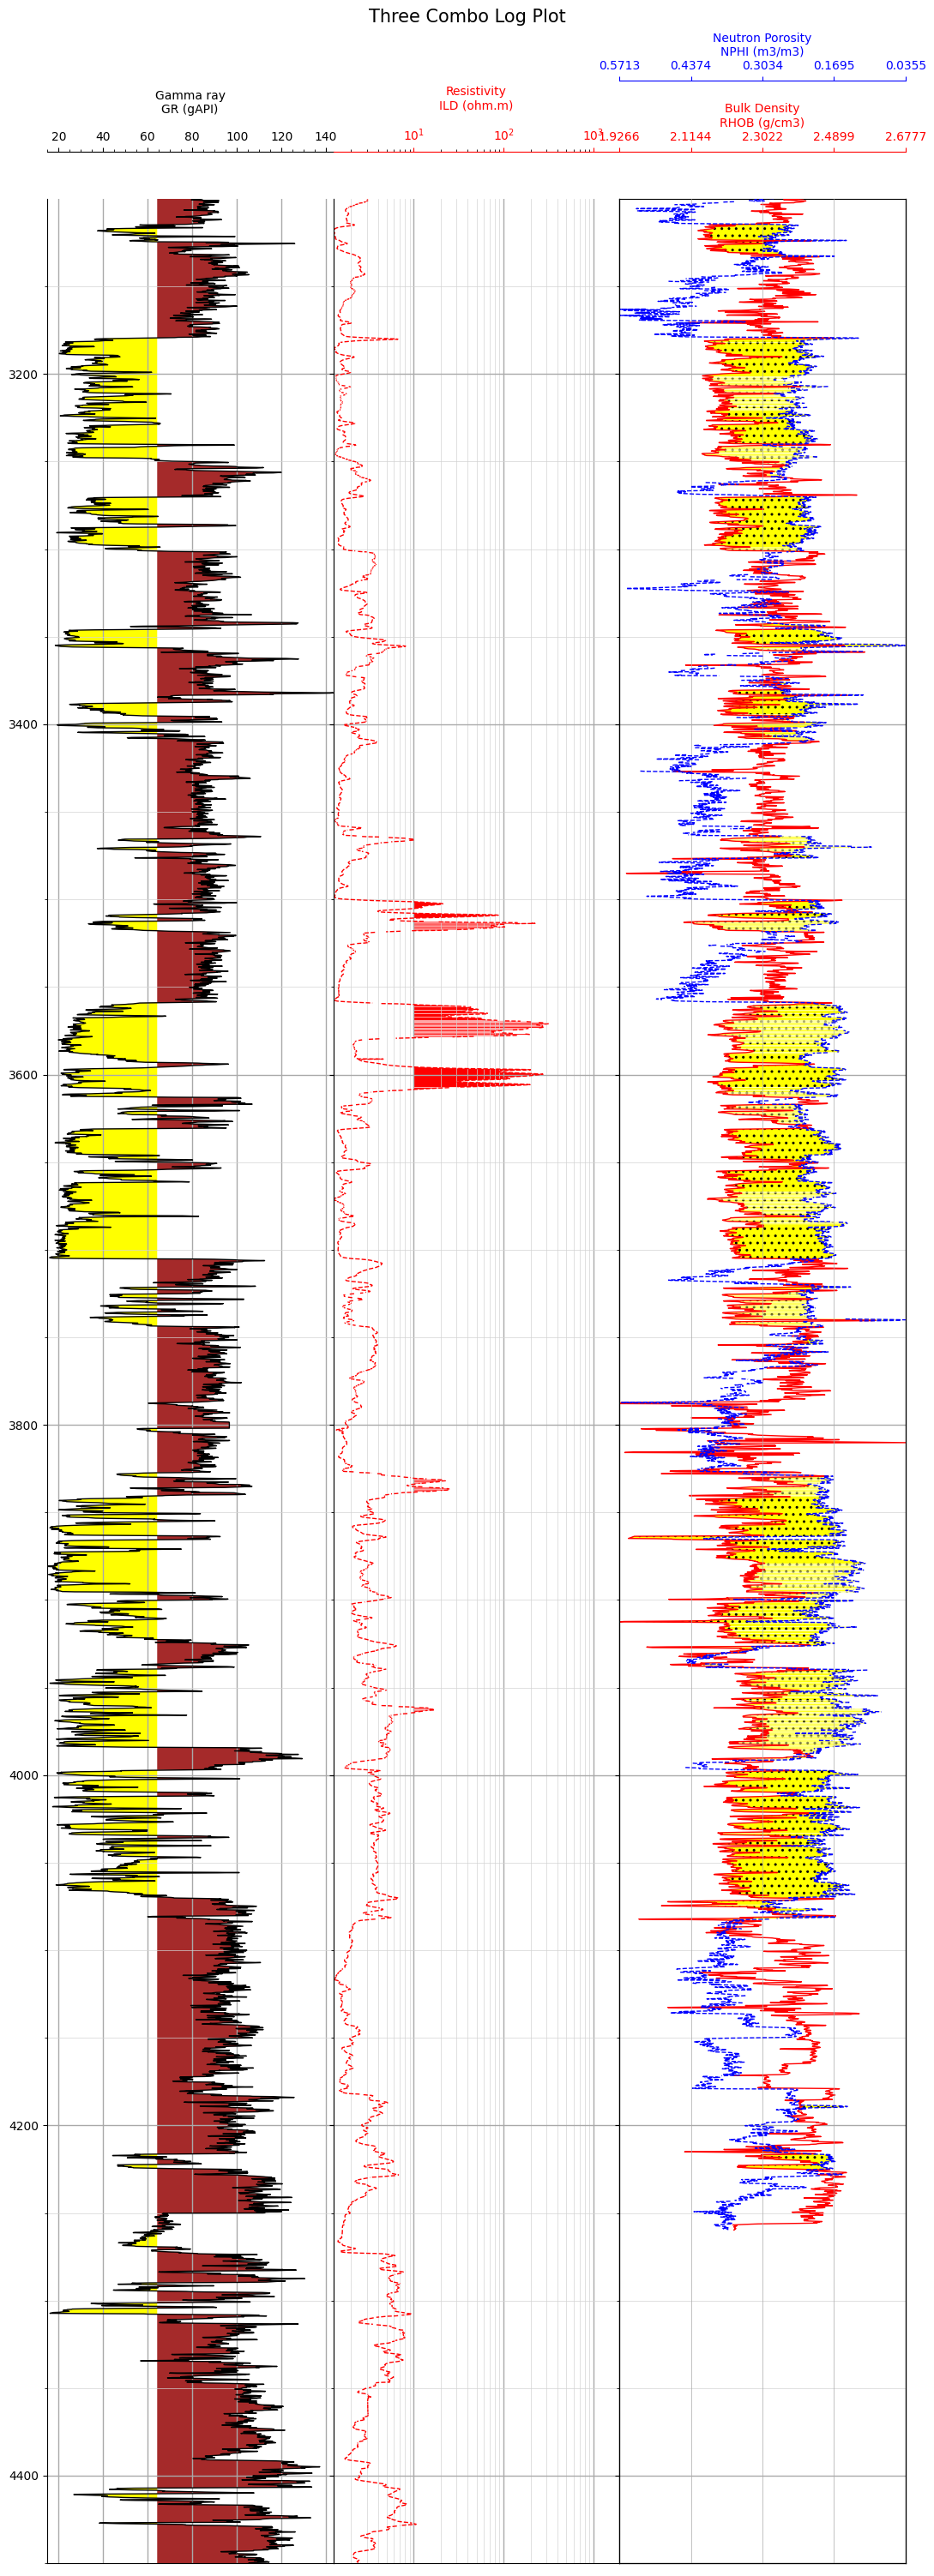

In [42]:
tripleCombo(well11, 'DEPTH', 'GR', 'RT', 'NPHI', 'RHOB', 3100,  4450,
            res_thres=10, fill='left', figsize=(11, 30))

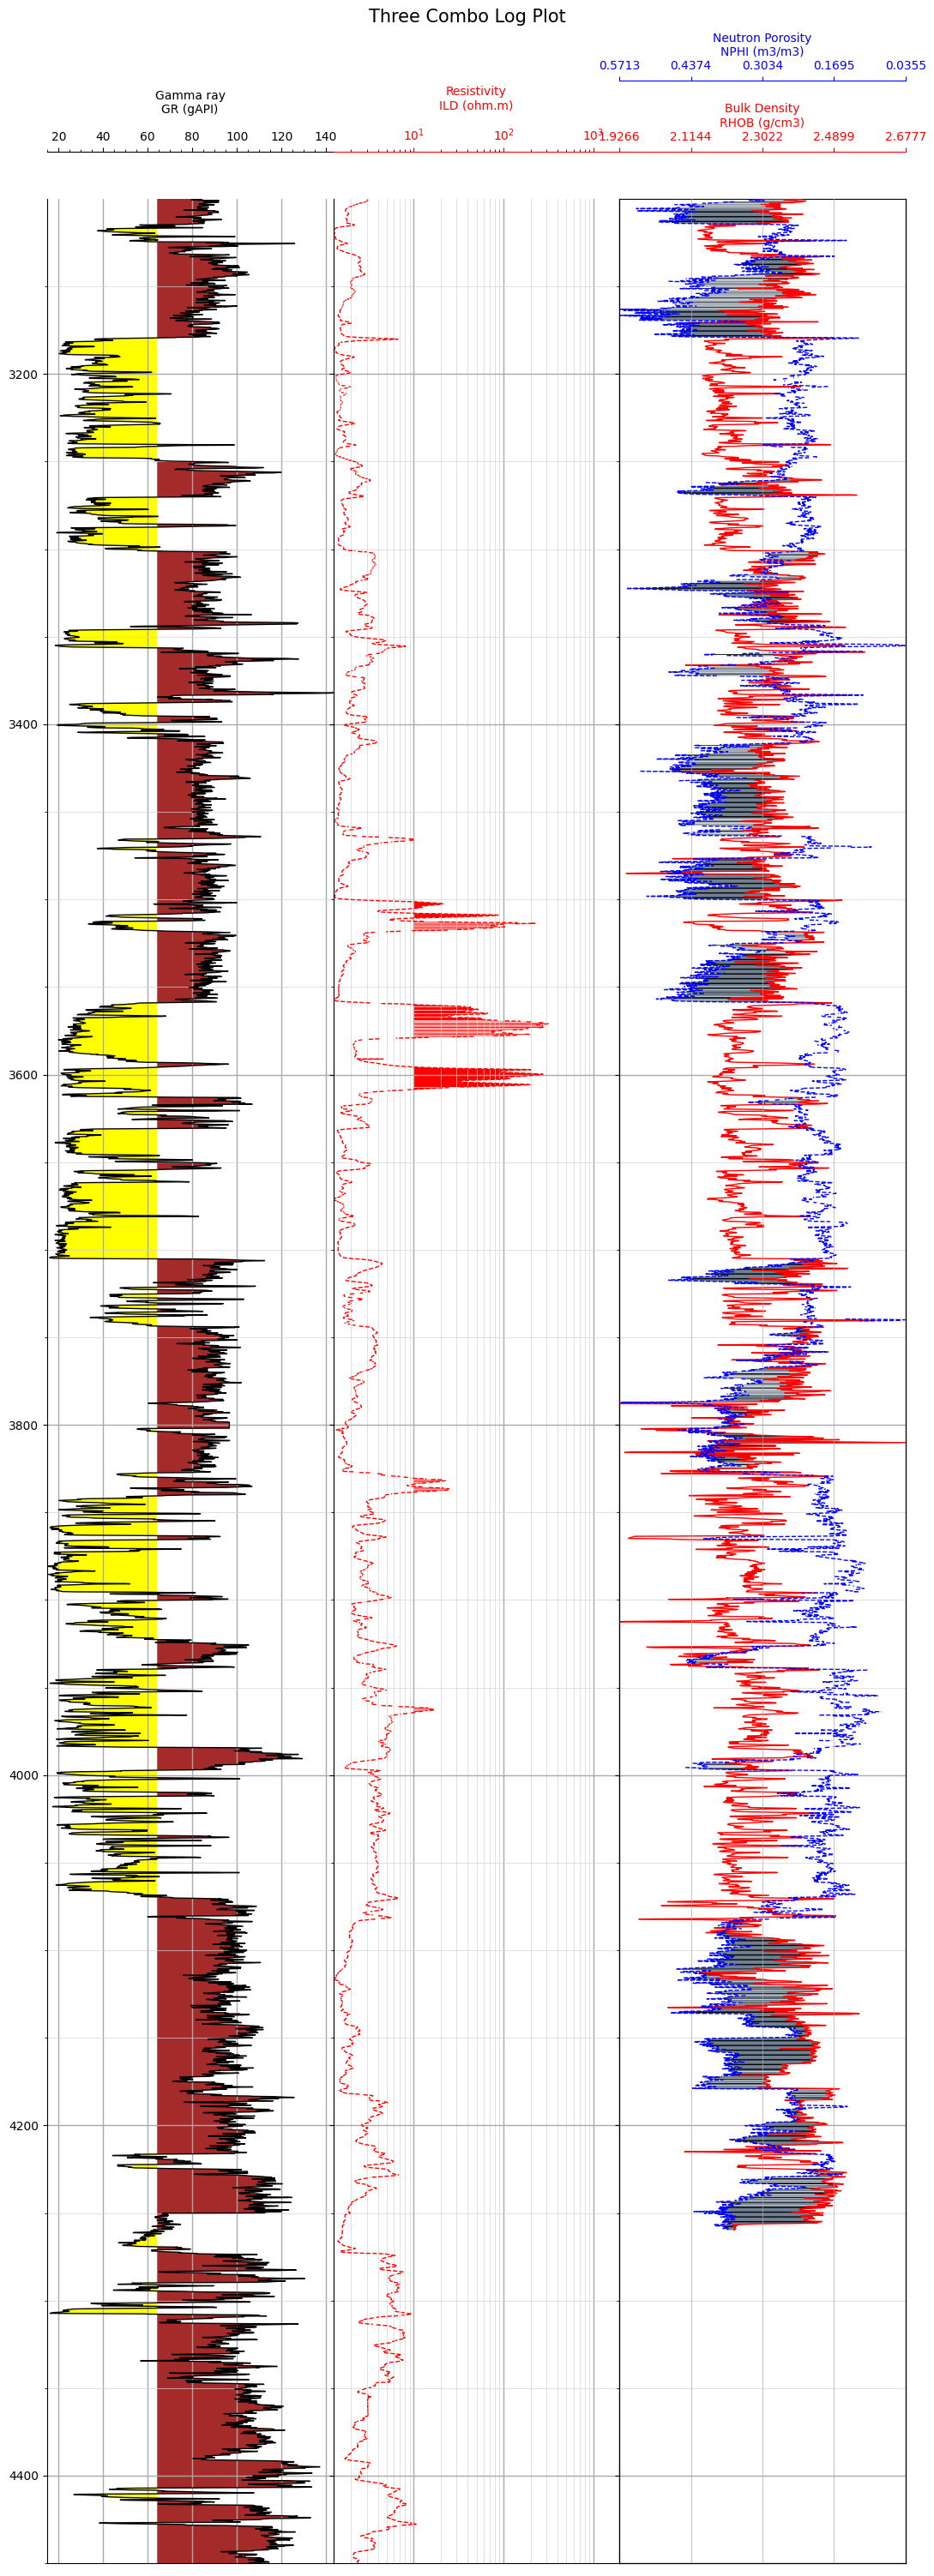

In [43]:
tripleCombo(well11, 'DEPTH', 'GR', 'RT', 'NPHI', 'RHOB', 3100,  4450,
            res_thres=10, fill='right', figsize=(11, 30))

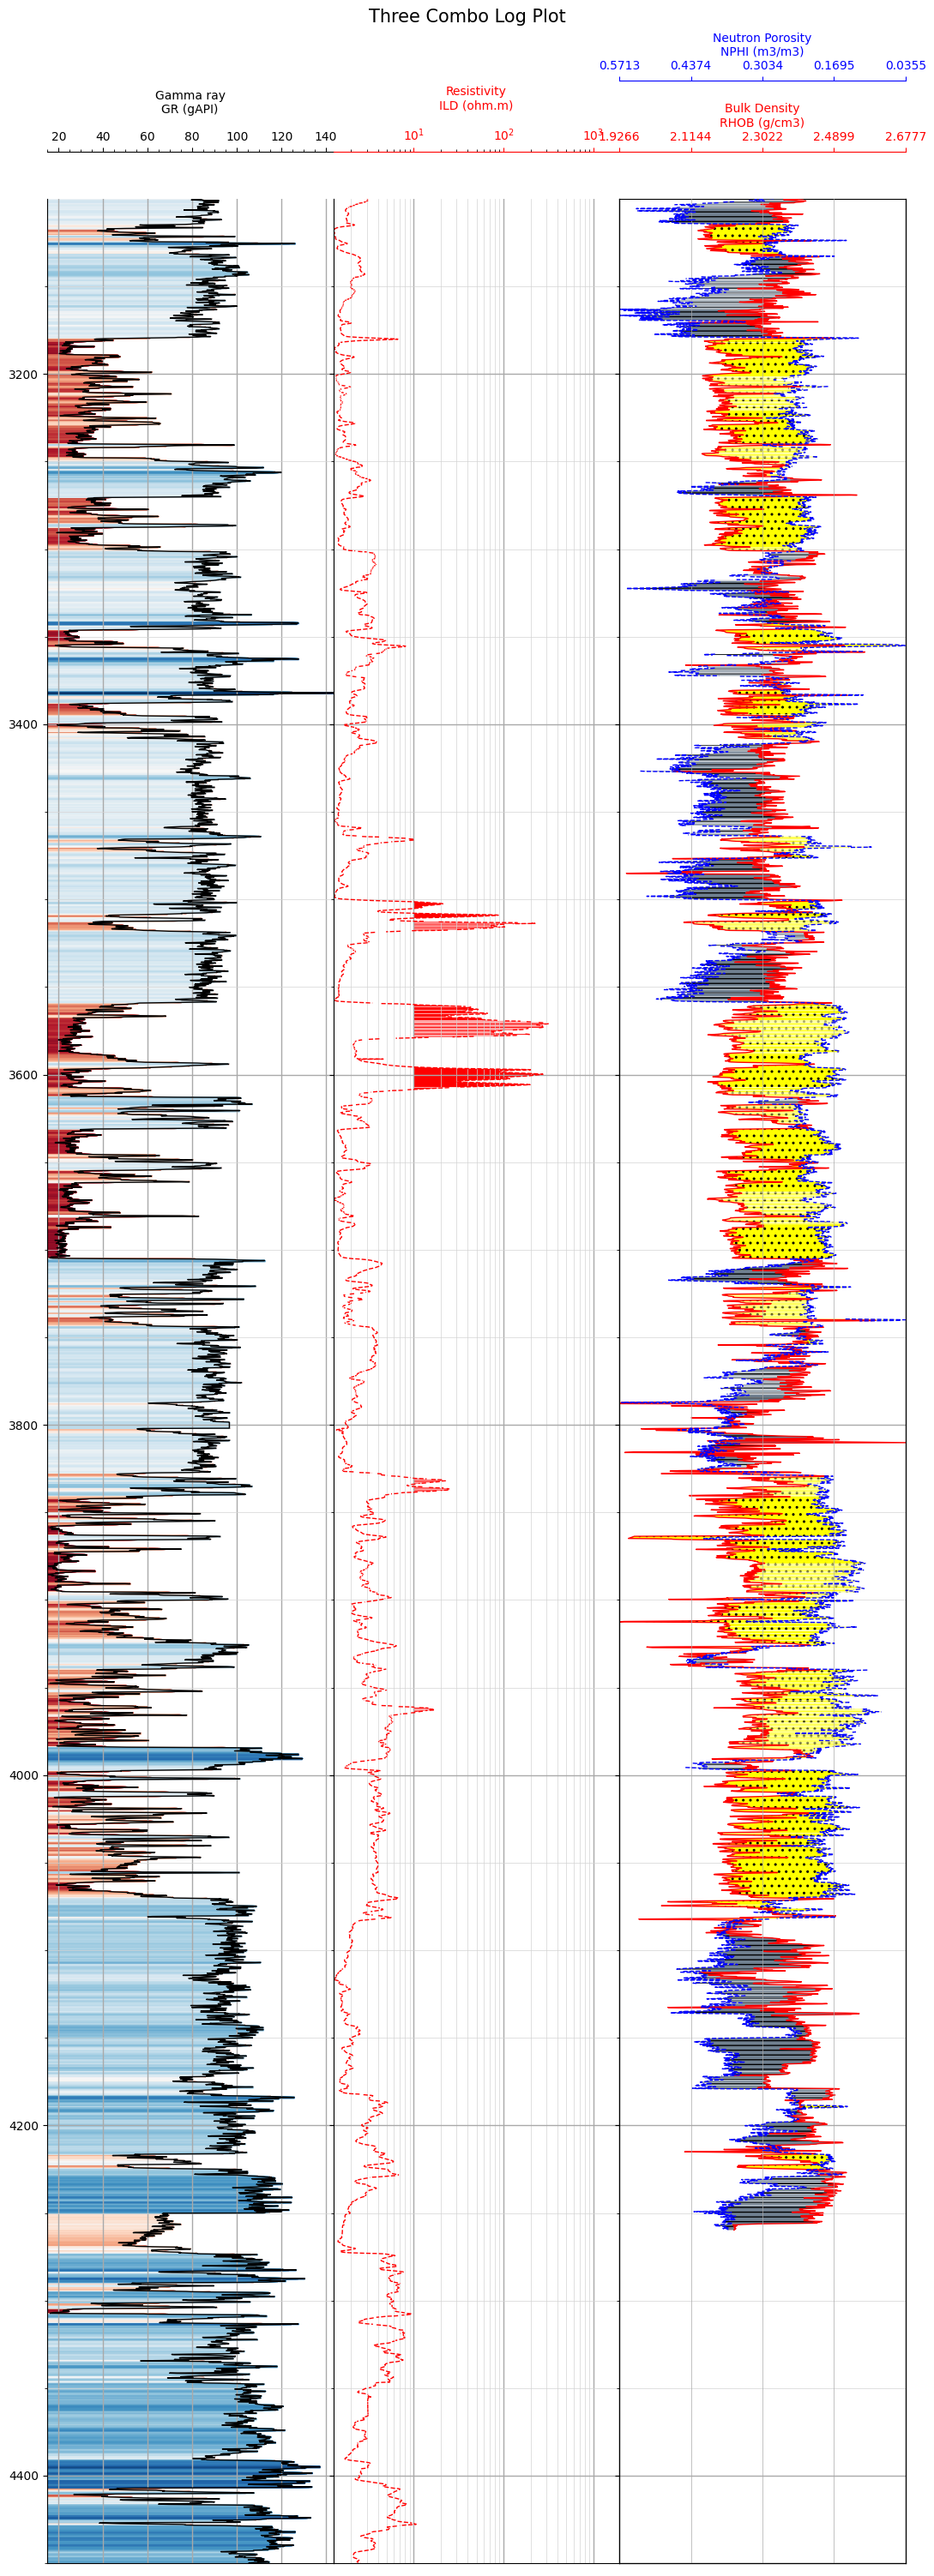

In [44]:
tripleCombo(well11, 'DEPTH', 'GR', 'RT', 'NPHI', 'RHOB', 3100,  4450,
            res_thres=10, fill='both', limit='left', palette_op='RdBu', figsize=(11, 30))

### Well tops/Zonation informtion

`Petrolib` also allows you to read in your picked well tops. Using the `Zonation` class, you canextract information about the reservoir tops and bases, and their names

In [48]:
well11tops = Zonation(well11, path='data/ataga 11.csv')

well11tops


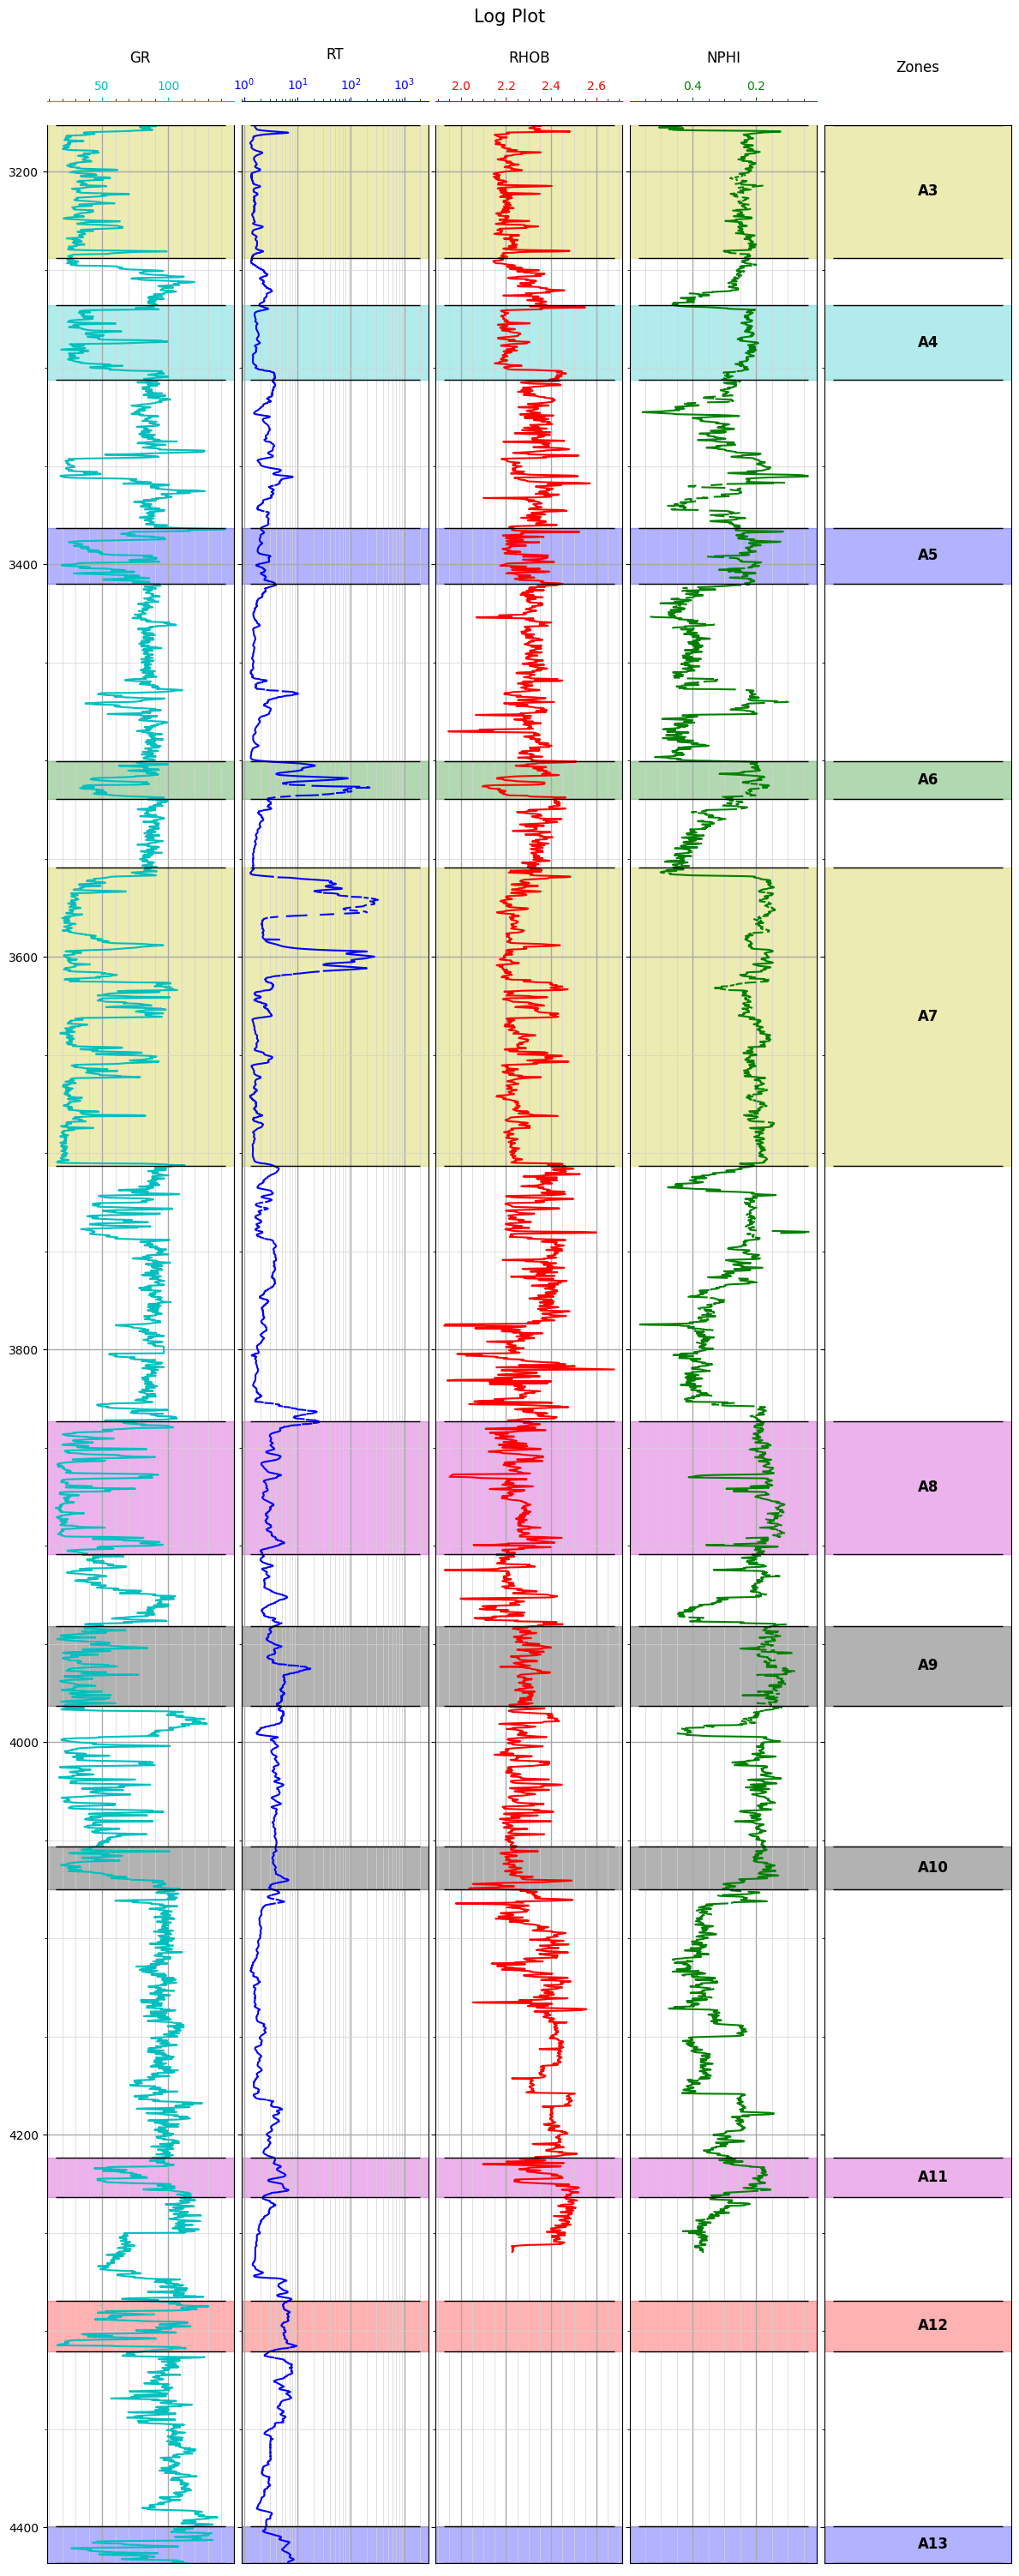

In [51]:
#extracts well information by calling the Zonation object
ztop, zbot, zn, fm = well11tops()

#plot the zone informations by calling the `plotZone` method
well11tops.plotZone('DEPTH', ['GR', 'RT', 'RHOB', 'NPHI'], min(ztop), max(zbot), figsize=(12, 30))

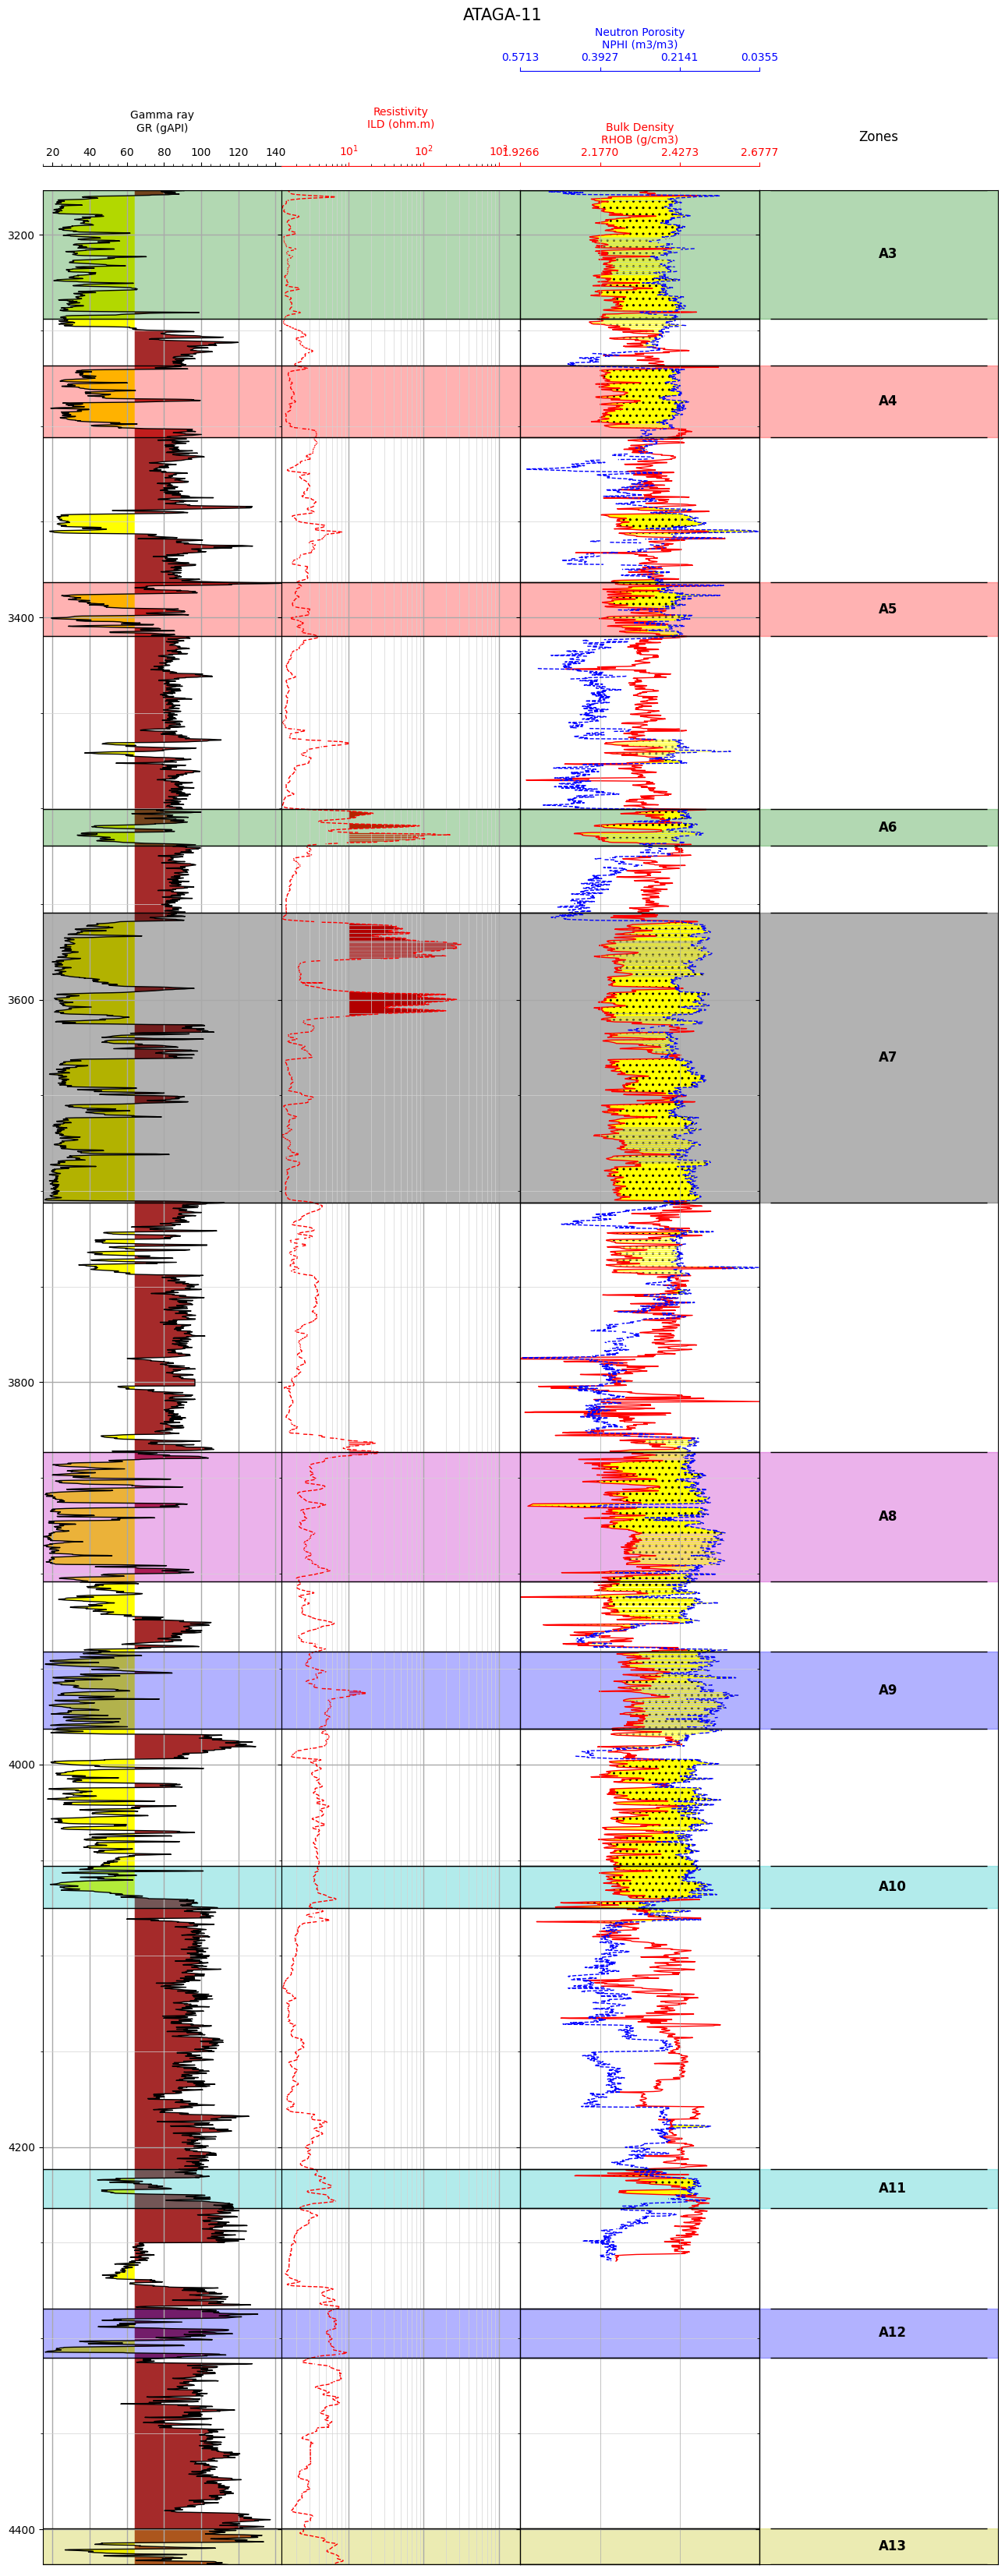

In [52]:
#plot three combo alongside the zone
plotZoneCombo(well11, 'DEPTH', 'GR', 'RT', 'NPHI', 'RHOB', min(ztop), max(zbot),
               ztop, zbot, zn, fill='left', limit=None, figsize=(13, 33), title='ATAGA-11')

# Petrophyscis

The actual petrophysics is carried out using the `Quanti` class. All petrophysical parameters are estimated from the methods contained in the class

The end result is to have a pay summary result/dataframe to help quantify the over-all quality of the reservoirs. Cutoff such as the porosity, shale volume and water saturation are applied to flag pay regions. The pay summary include:

* net, gross and not net thicknesses
* % net-to-gross
* average volume of shale
* average porosity
* bulk volume of water
* water saturation.

Here we're going to quantify just two reservoirs

In [55]:
pp = Quanti(well11, zonename=zn[:2], ztop=ztop[:2], zbot=zbot[:2], f_mids=fm[:2], depth='DEPTH', gr='GR', rt='RT', nphi='NPHI', rhob='RHOB')

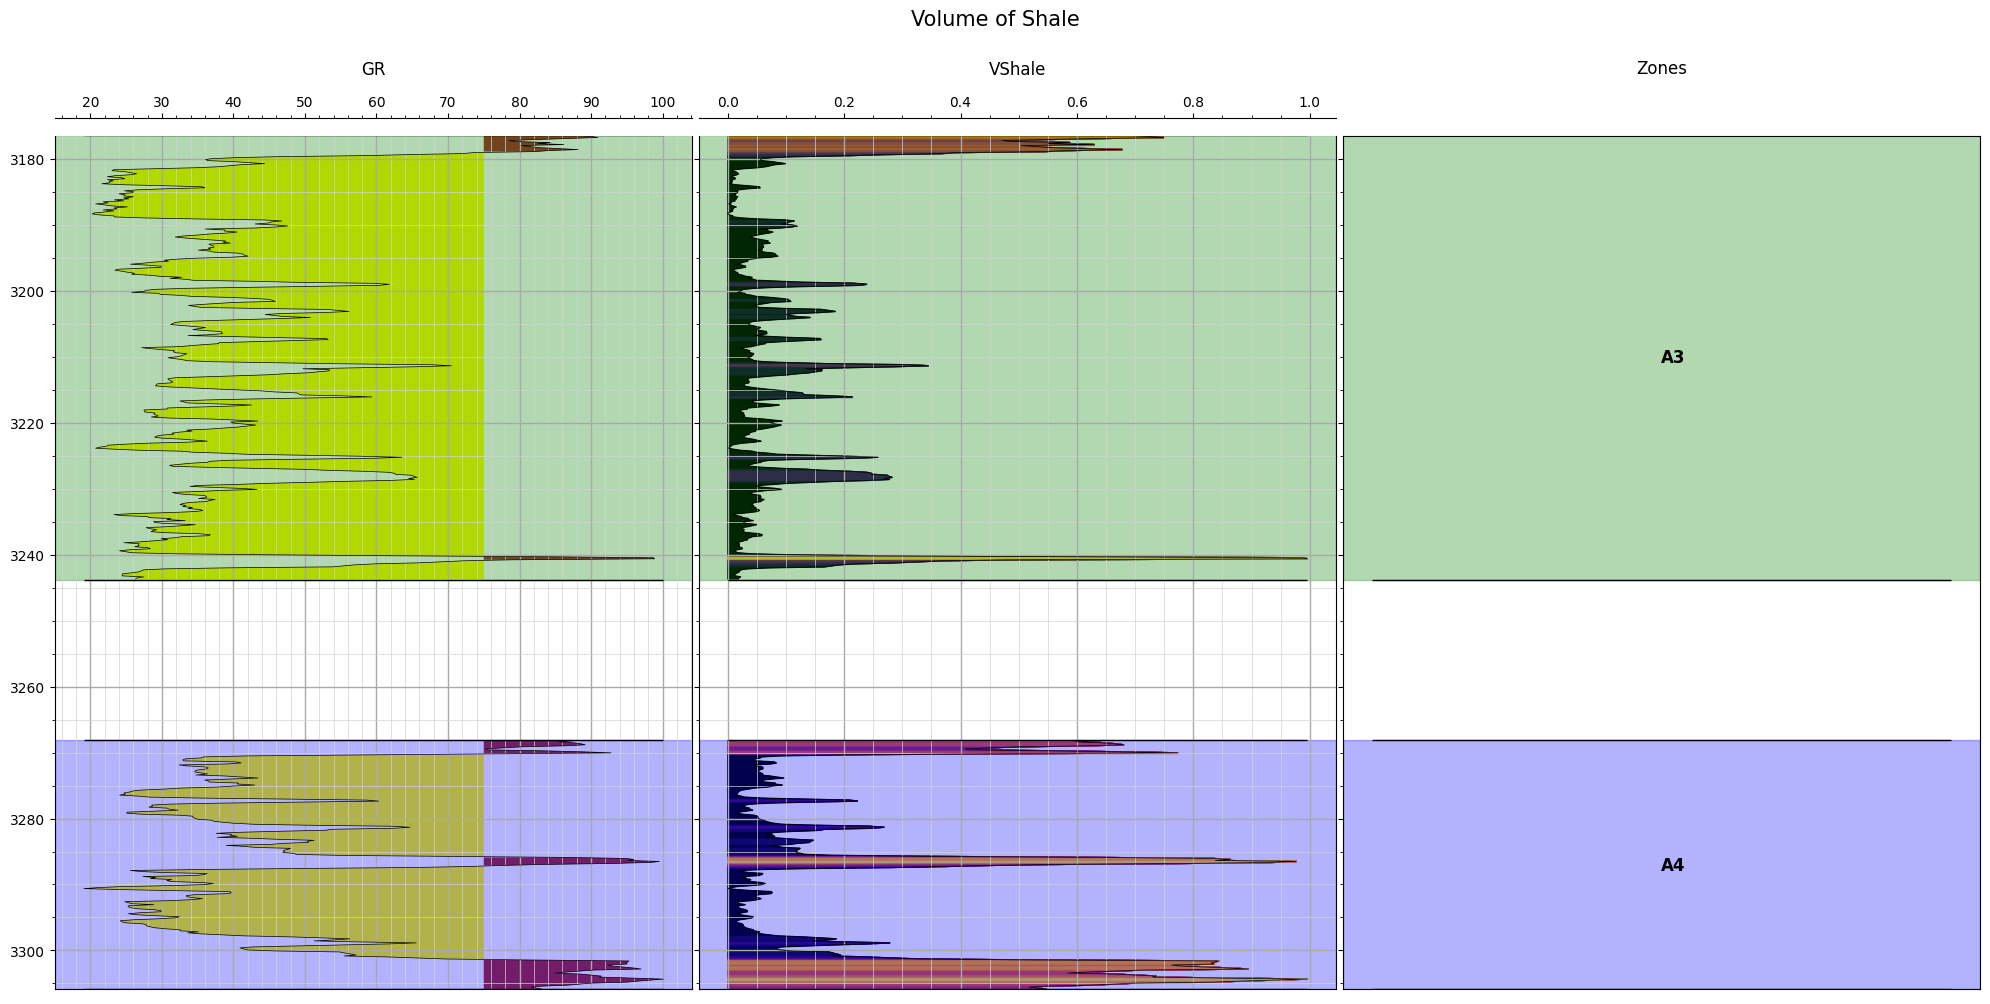

In [63]:
#various methods can be used to estimate the VSH, you can refer to documentation
#low VSH response is seen
vshale = pp.vshale(method='larionov_ter', show_plot=True, palette_op='inferno', figsize=(20, 10))

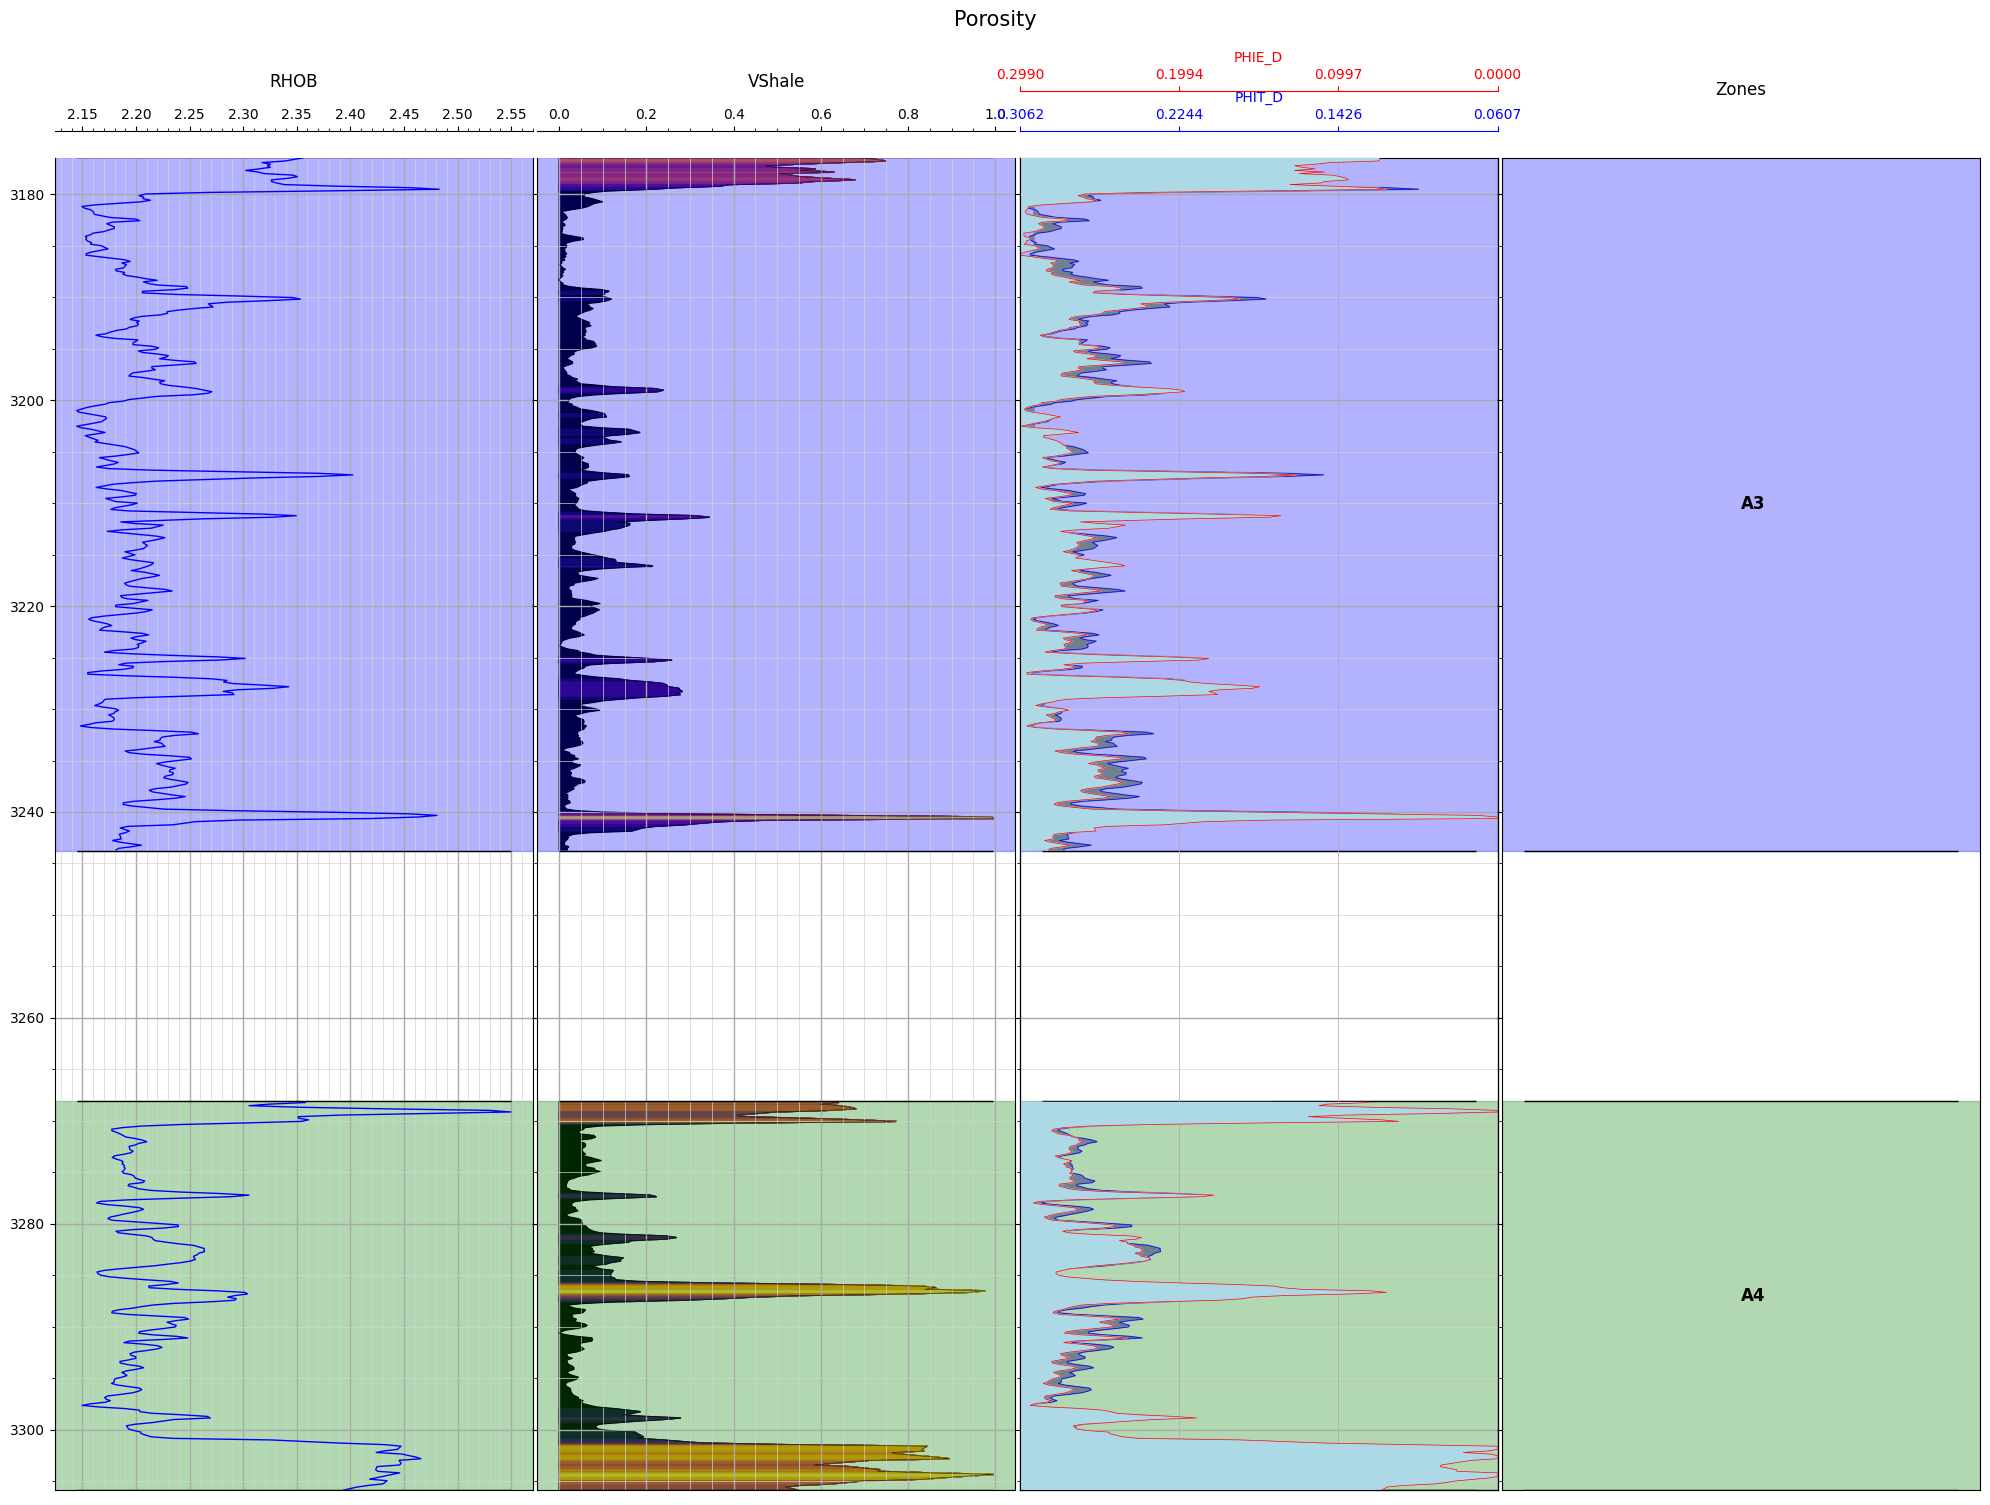

In [62]:
por = pp.porosity(method='density', show_plot=True, figsize=(20, 15))

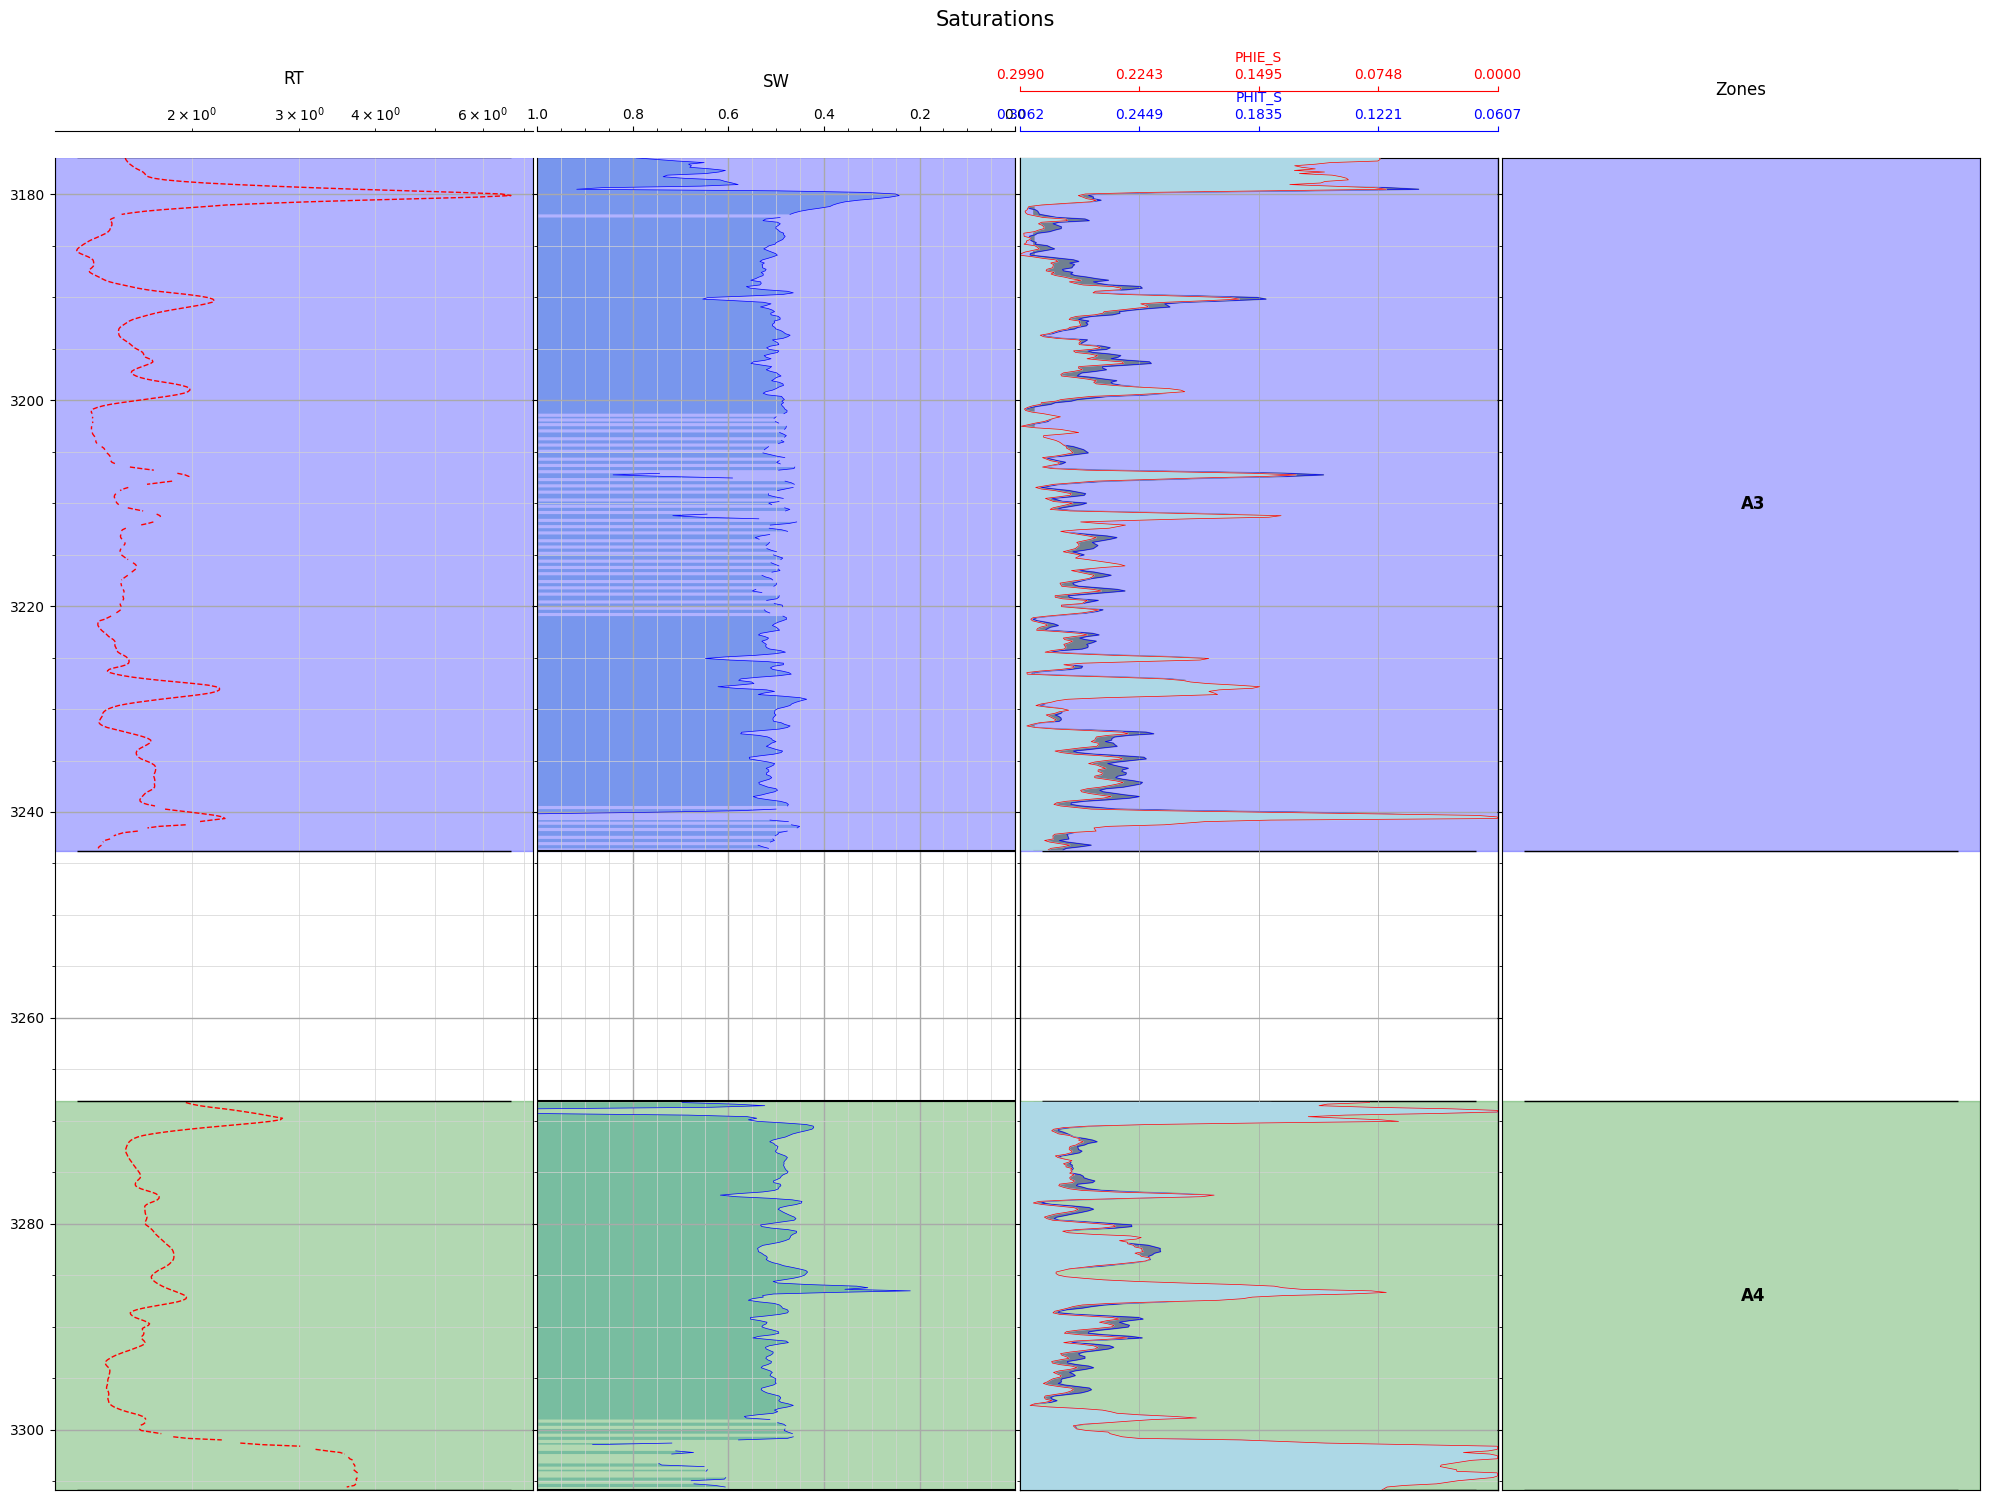

In [64]:
#water saturation
sat = pp.water_saturation(method='simmandoux', show_plot=True, figsize=(20, 15))

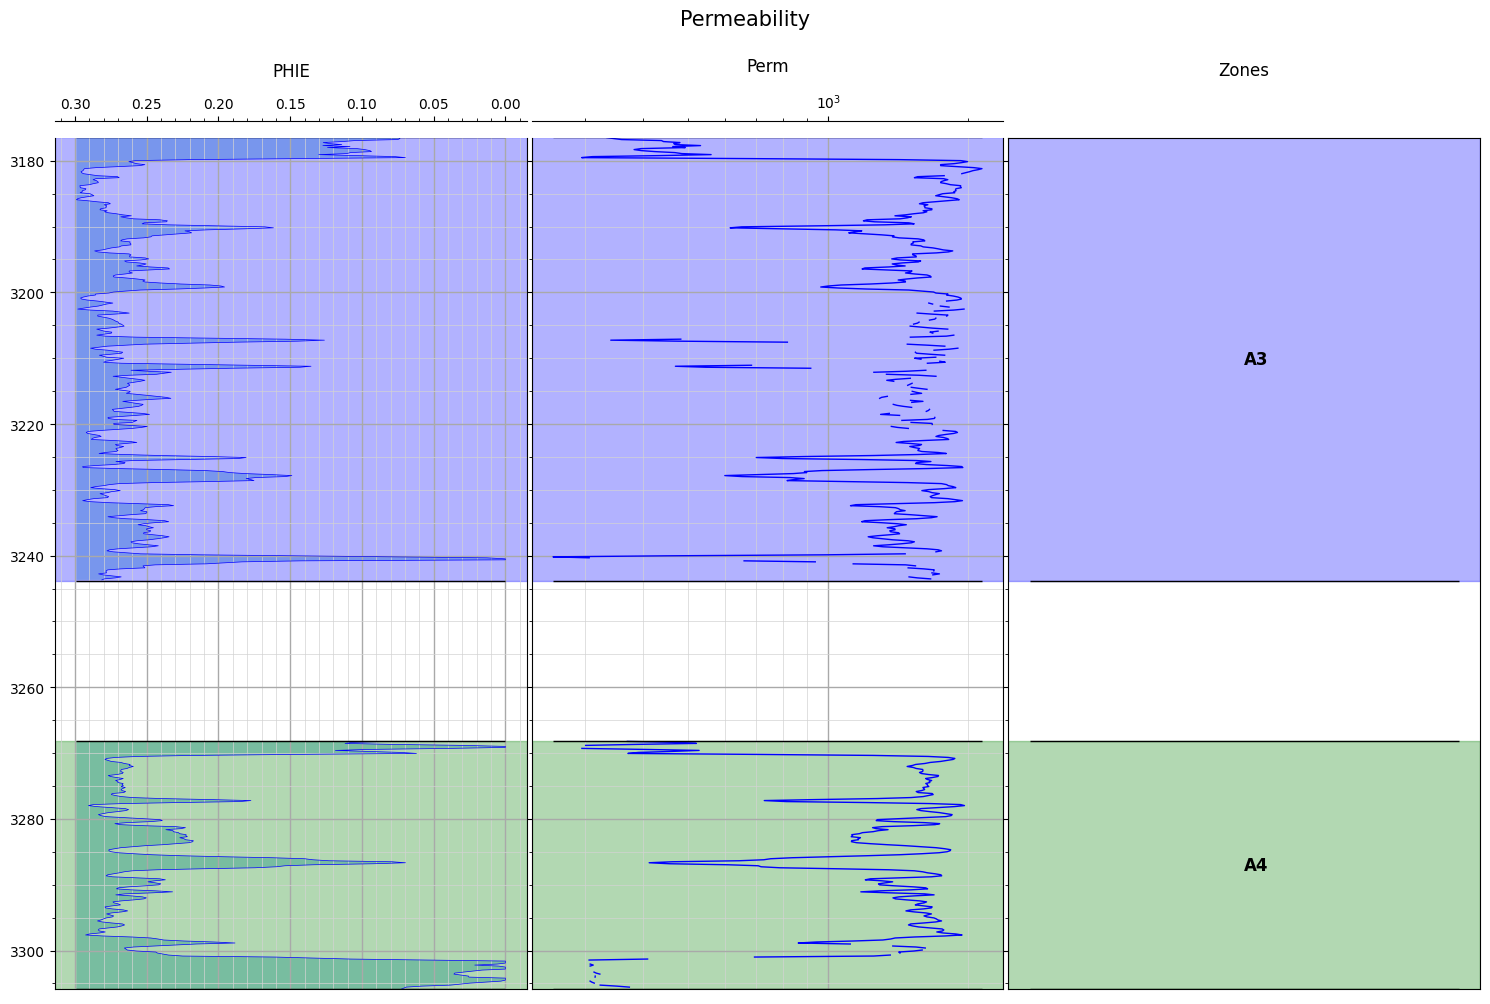

In [93]:
#permeability
plt.style.use('default')
perm = pp.permeability(show_plot=True, figsize=(15, 10))

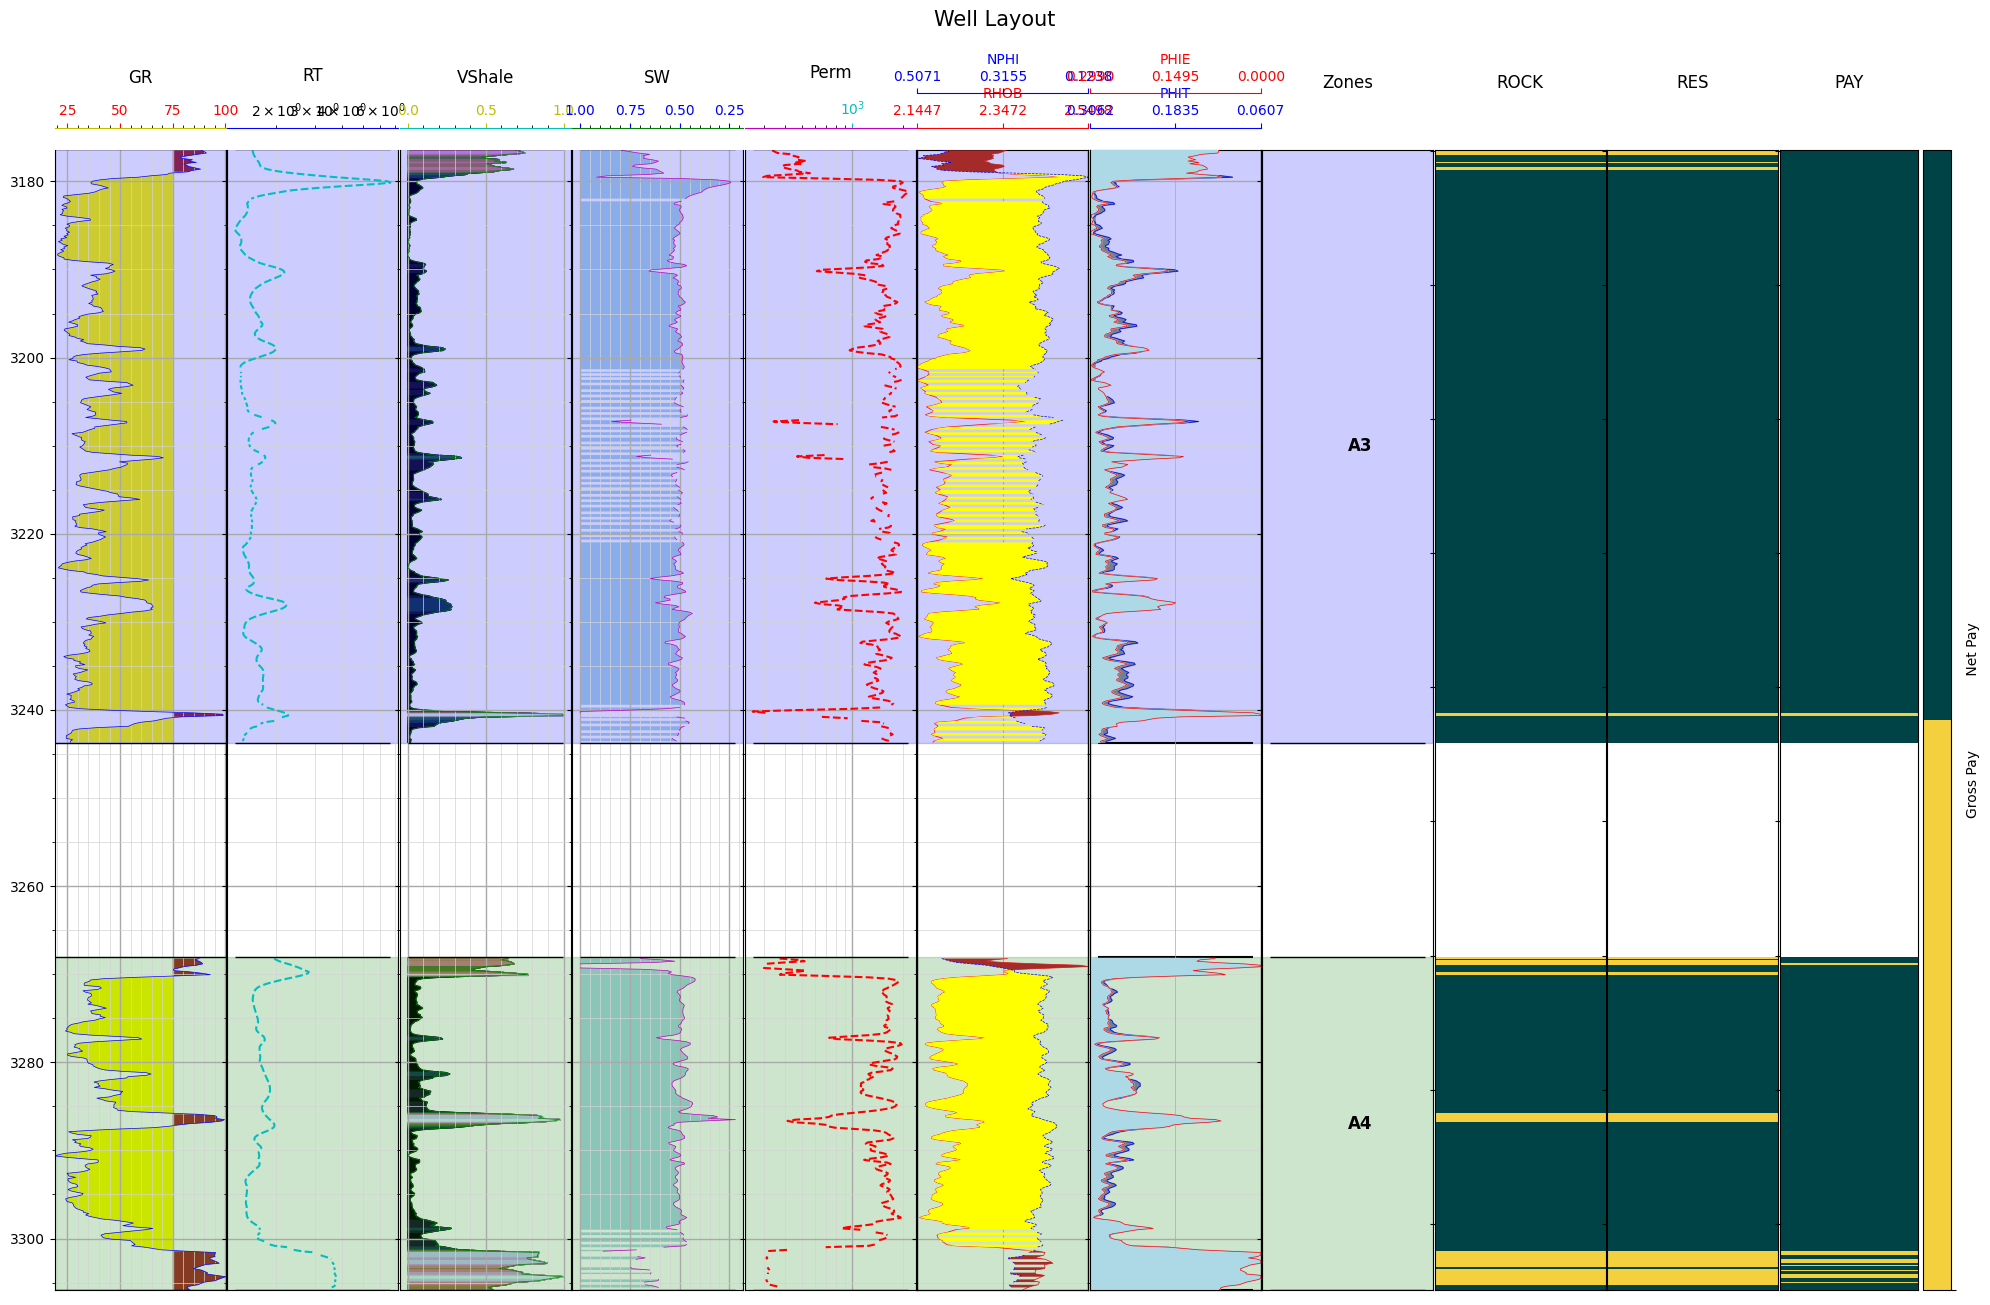

In [69]:
#applies VSH, SW and PHI cut-offs to flag payfrom non-pay regions
report = pp.flags(vsh_cutoff=.6, por_cutoff=.2, sw_cutoff=.8, show_plot=True, palette_op='cubehelix', figsize=(20, 13))

In [90]:
#displays pays summary results
table = pp.paySummary(name='ATG-11')
table

In [ ]:
#ave pay summary result to excel file in the working directory
pp.save('data/ATG-11')

In [89]:
#displays report of methods and cutoffs used
pp.report()

# Picket and Density Crossplot

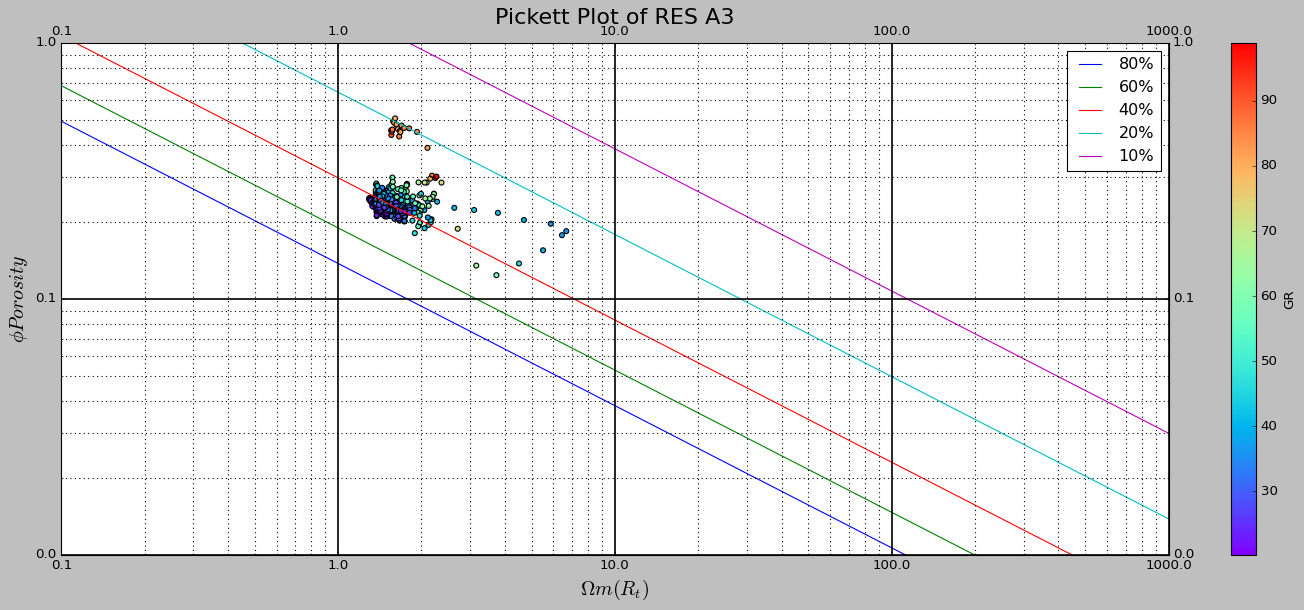

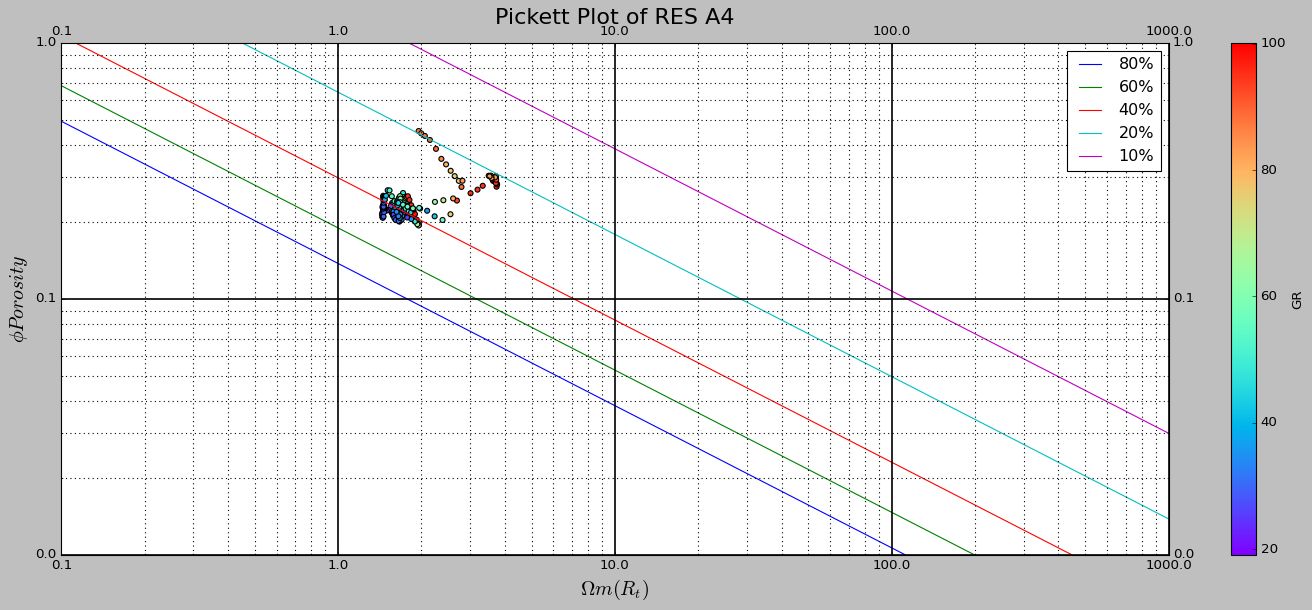

In [87]:
# from petrolib.interp import picketPlot, crossPlot

#Picket Plot for the first two reservoirs

for i, zone in enumerate(zn[:2]):
    plt.style.use('classic') 
    res = por[i]
    picketPlot(res, color_code='num', hue='GR', cmap='rainbow', res_name=zone)

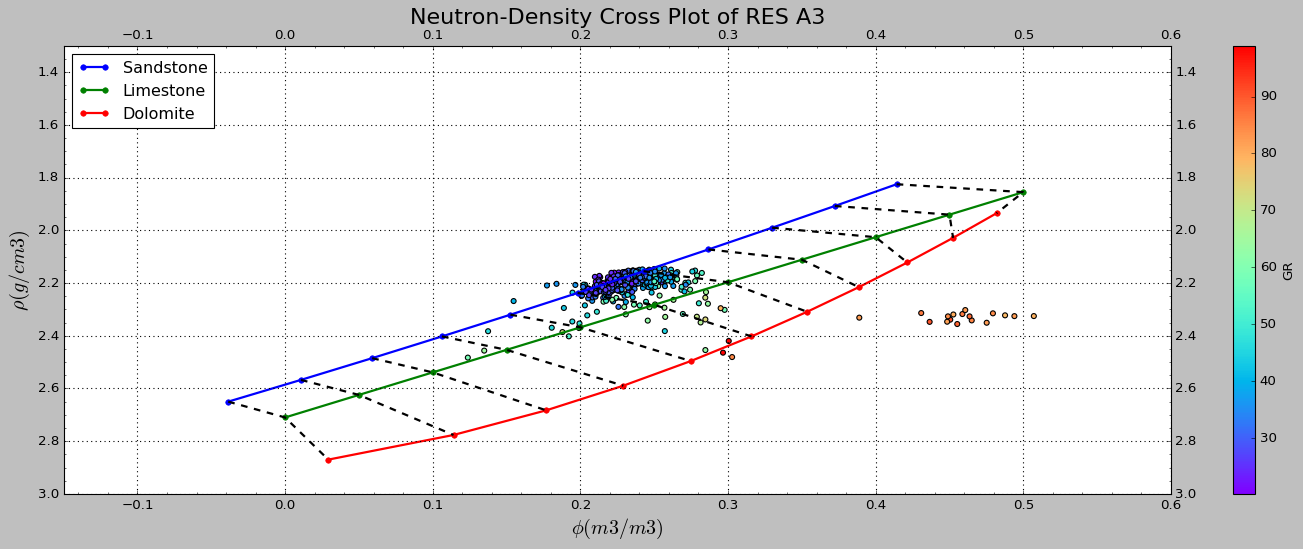

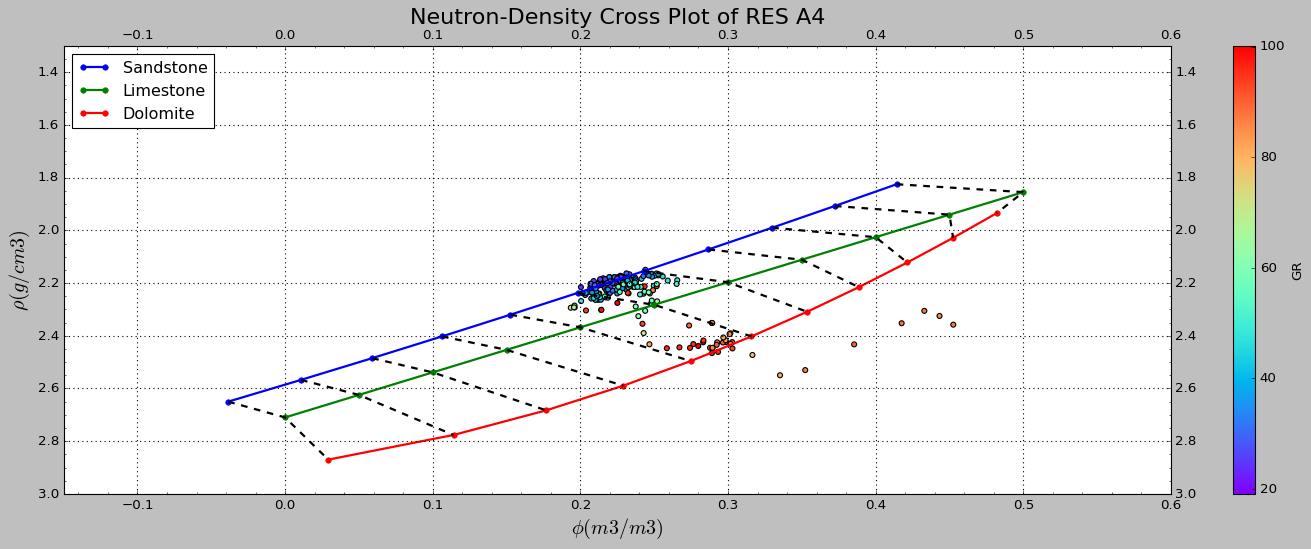

In [88]:

#Crossplot

for i, zone in enumerate(zn[:2]):
    plt.style.use('classic')
    res = por[i]
    crossPlot(res, 'NPHI', 'RHOB', color_code='num', hue='GR', cmap='rainbow', res_name=zone)